In [1]:
import re, sys, math
import glob
import random
import json
import os 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import cv2 

%matplotlib inline

In [16]:
#########################################
#
# Methods to load 4d np array for images from ./data directory
# 4D tensor with shape: (samples, rows, cols, channels=1)
#
#########################################

def load_images_and_labels(data, normalize= True):
    """Function to load images and labels from .npy file into a 4d numpy array
    before we feed them into U-net model. 

    Note:
    Image files will be normalized based on pixel values by default.       

    Args:
        data (:dict): dictionary with full path to .npy files for images and labels.
        normalize (:boolean, optional): Applies pixel normalization if True. Default value is True.
    
    Returns:
       numpy arrays  of images and labels.
    """
    print('-'*30)
    print('load np arrays of images and labels...')
    print('-'*30)
    imgfile = data["images"]
    labelfile = data["labels"]
    print ("Loading files : ", imgfile, labelfile)
    
    im = np.load(imgfile)
    lb = np.load(labelfile)
    if (normalize == True):
        images = im.astype('float32')
        labels = lb.astype('float32')
        ##Normalize the pixel values, (between 0..1)
        x_min = images.min(axis=(1, 2), keepdims=True)
        x_max = images.max(axis=(1, 2), keepdims=True)
        images2 = (images - x_min)/(x_max-x_min)
        print("shape, max, min, mean of original image set:", images.shape, images.max(), images.min(), images.mean())
        print("shape, max, min, mean after normalization  :", images2.shape, images2.max(), images2.min(), images2.mean())
        print("shape, max, min, mean of labels :", labels.shape, labels.max(), labels.min(), labels.mean())
    
    else :
        images2 = im
        labels = lb
        print("shape, max, min, mean of images :", images2.shape, images2.max(), images2.min(), images2.mean())
        print("shape, max, min, mean of labels :", labels.shape, labels.max(), labels.min(), labels.mean())
    
    return images2, labels

def load_images_and_labels_no_preproc(data):
    print('-'*30)
    print('load np arrays of images and labels...')
    print('-'*30)
    imgfile = data["images"]
    labelfile = data["labels"]
    print ("Loading files : ", imgfile, labelfile)

    images = np.load(imgfile)
    labels = np.load(labelfile)
#     im = np.load(imgfile)
#     lb = np.load(labelfile)
#     images = im.astype('float32')
#     labels = lb.astype('float32')
    
#     ##Normalize the pixel values, (between 0..1)
#     x_min = images.min(axis=(1, 2), keepdims=True)
#     x_max = images.max(axis=(1, 2), keepdims=True)
#     images2 = (images - x_min)/(x_max-x_min)

    print("shape, max, min, mean of original image set:", images.shape, images.max(), images.min(), images.mean())
#    print("shape, max, min, mean after normalization  :", images2.shape, images2.max(), images2.min(), images2.mean())
    print("shape, max, min, mean of labels :", labels.shape, labels.max(), labels.min(), labels.mean())
    return images, labels


def load_images(imgfile, normalize= True):
    """Function to load images  from .npy file into a 4d numpy array
    before we feed them into U-net model. 

    Note:
    Image files will be normalized based on pixel values by default.       

    Args:
        imgfile (:string): .npy file name with full path for images .
        normalize (:boolean, optional): Applies pixel normalization if True. Default value is True.
    
    Returns:
       numpy array  of images.
       
    """
    print('-'*30)
    print('load np arrays of images ...')
    print('-'*30)
    print ("Loading files : ", imgfile)
    
    im = np.load(imgfile)
    if (normalize == True):
        images = im.astype('float32')
        ##Normalize the pixel values, (between 0..1)
        x_min = images.min(axis=(1, 2), keepdims=True)
        x_max = images.max(axis=(1, 2), keepdims=True)
        images2 = (images - x_min)/(x_max-x_min)
        print("shape, max, min, mean of original image set:", images.shape, images.max(), images.min(), images.mean())
        print("shape, max, min, mean after normalization:", images2.shape, images2.max(), images2.min(), images2.mean())
    else :
        images2 = im
        print("shape, max, min, mean of images:", images2.shape, images2.max(), images2.min(), images2.mean())
   
    return images2



def plot_learning_history(file_p):
    """Function to plot learning history captured during model training.       

    Args:
        file_p(:string): learning history file (.json) with full path.
    
    Returns:
       None.
       
    """
    try:
        with open(file_p, 'r') as file:
            history = json.load(file)
    except (OSError, ValueError):  # file does not exist or is empty/invalid
        print ("File does not exist")
        
    # list all data in history
    #print(history.keys())

    print('-'*30)
    print ("Model Parameters")
    for key in history:
        if (key.startswith("tr_") == True):
            print (key, " : ", history[key])
    print('-'*30)
    print ("Evaluation on Test set")
    for key in history:
        if (key.startswith("eval_") == True):
            print (key, " : ", history[key])
            
    print('-'*30)
    print ("Values at first and last epoch")
    print('-'*30)
    for key in history:
        if (key.startswith("tr_") != True):
            print (key, " : ", history[key][0], ",", history[key][-1])
    print('-'*30) 
    print('-'*30)
    legend = []
    # summarize history for accuracy
    if 'dice_coeff' in history.keys():
        plt.plot(history['dice_coeff'])
        plt.plot(history['val_dice_coeff'])
        legend.append('test_dicecoef')
        legend.append('val_dicecoef')
        #plt.title('model accuracy(dice_coeff)')
    if 'val_acc' in history.keys():
        plt.plot(history['acc'])
        plt.plot(history['val_acc'])
        #plt.title('Model accuracy')
    if 'categorical_accuracy' in history.keys():
        plt.plot(history['categorical_accuracy'])
        plt.plot(history['val_categorical_accuracy'])
        legend.append('test_cat_acc')
        legend.append('val_cat_acc')
        #plt.title('categorical_accuracy')
    if 'binary_accuracy' in history.keys():
        plt.plot(history['binary_accuracy'])
        plt.plot(history['val_binary_accuracy'])
        legend.append('test_binary_acc')
        legend.append('val_binary_acc')
        #plt.title('Binary_accuracy')

    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(legend, loc='lower right')
    plt.title('Accuracy Metrics')
    plt.grid()
    plt.show()
    # summarize history for loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.grid()
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

def read_performance_statistics(file_p):
    """Function to read performance statistics captured during model training.       

    Args:
        file_p(:string): performance statistics file (.json) with full path.

    Returns:
       None.
       
    """
    perf_list = ['logloss', 'weighted_logloss', 'accuracy', 'weighted_accuracy','true_positive', 'false_positive', 'true_negative','false_negative', \
                 'precision','recall', 'f1_score' ]
    try:
        with open(file_p, 'r') as file:
            perf = json.load(file)
    except (OSError, ValueError):  # file does not exist or is empty/invalid
        print ("File does not exist")
        perf = {}

    print('-'*30)
    for key in perf_list:
        if key in perf.keys():
            print (key, " : ", perf[key])
    print('-'*30) 
    print('-'*30)
    return perf
    # list all data in history
    
def get_performance_statistics(y_true_f, y_pred_f):
    """Function to plot learning history captured during model training.       

    Args:
        file_p(:string): learning history file (.json) with full path.

    Returns:
       perf(:dict): dictionary of perf statistics
       
    """   
    
#     y_true = np.load(y_true_f)
#     y_pred = np.load(y_pred_f)

    y_true = y_true_f.flatten()
    y_pred = y_pred_f.flatten()

    sample_weights = np.copy(y_true)
    sample_weights[sample_weights == 1] = 1.
    sample_weights[sample_weights == 0] = .2
    
    epsilon = 1e-7
    y_pred[y_pred<=0.] = epsilon
    y_pred[y_pred>=1.] = 1. -epsilon
    
    perf = {}
    
    score = log_loss (y_true, y_pred)
    score2 = log_loss (y_true, y_pred, sample_weight = sample_weights)
    perf["logloss"] = score
    perf["weighted_logloss"] = score2
    perf["accuracy"] = math.exp(-score)
    perf["weighted_accuracy"] = math.exp(-score2)

    y_pred = np.round(y_pred)
    perf["precision"] = precision_score(y_true, y_pred, average="binary")
    perf["recall"] = recall_score(y_true, y_pred, average="binary")
    perf["f1_score"] = f1_score(y_true, y_pred, average="binary")

    cm = confusion_matrix(y_true, y_pred)
    perf["true_positive"] = int(cm[1][1])
    perf["false_positive"] = int(cm[0][1])
    perf["true_negative"] = int(cm[0][0])
    perf["false_negative"] = int(cm[1][0])
    
    #cm.print_stats()
    return perf
    

def show_performance_statistics (y_true_f, y_pred_f):
    """Function to compute and display performanc statistics using labels and prections.       

    Args:
        y_true_f(:string):  label file (.npy) with full path.
        y_pred_f(:string):  predictions file (.npy) with full path.
        
    Returns:
       None.
    
    Note:
        prection file should have the sigmoid outputs (not the rounded values).
    """ 
       
    y_true = np.load(y_true_f)
    y_pred = np.load(y_pred_f)
    #print (y_true.shape, y_pred.shape)
    
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    weight = 0.8
    sample_weights = np.copy(y_true)
    sample_weights[sample_weights == 1] = 1.
    sample_weights[sample_weights == 0] = .2
    
    
    epsilon = 1e-7
    y_pred[y_pred<=0.] = epsilon
    y_pred[y_pred>=1.] = 1. -epsilon
    
    #print (y_true.shape, y_pred.shape)

    score = log_loss (y_true, y_pred)
    score2 = log_loss (y_true, y_pred, sample_weight = sample_weights)
    acc = math.exp(-score)
    acc2 = math.exp(-score2)
    y_pred = np.round(y_pred)
    print('-'*30)
    print ("Loss and Accuracy")
    print('-'*30)
    
    print ("log_loss : ", score,  "  Accuracy: ", acc)
    print ("weighted log_loss : ", score2,  "  Weighted_accuracy: ", acc2)
    print('-'*30)
    
    print ("Model Performance")
    print('-'*30)
    prec = precision_score(y_true, y_pred, average="binary")
    rec = recall_score(y_true, y_pred, average="binary")
    f1 = f1_score(y_true, y_pred, average="binary")
    print("precision :", prec)
    print("recall :", rec) 
    print("f1 score :", f1)
    
    cm = confusion_matrix(y_true, y_pred)
    #cm.print_stats()
    true_p = cm[1][1]
    false_p = cm[0][1]
    true_n = cm[0][0]
    false_n = cm[1][0]
    print ("")
    print ("true_p = %d, false_p = %d, true_neg = %d, false_neg = %d"%(true_p, false_p, true_n, false_n))
    print ("confuion matrix")
    print (cm)
    print ("")
    plt.matshow(cm)
    plt.title('Confusion matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.colorbar()
    plt.show()
    
    print('-'*30)
    print('-'*30)

def compute_performance_statistics (y_true_f, y_pred_f):
    """Function to compute performanc statistics using labels and prections.       

    Args:
        y_true_f(:string):  label file (.npy) with full path.
        y_pred_f(:string):  predictions file (.npy) with full path.
        
    Returns:
       perf(:dict): dictionary of perf statistics.
    
    Note:
        prection file should have the sigmoid outputs (not the rounded values).
    """
    
    y_true = np.load(y_true_f)
    y_pred = np.load(y_pred_f)
    
    y_true_o = np.load(y_true_f)
    y_pred_o = np.load(y_pred_f)
    #print (y_true.shape, y_pred.shape)
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    sample_weights = np.copy(y_true)
    sample_weights[sample_weights == 1] = 1.
    sample_weights[sample_weights == 0] = .2
    
    
    epsilon = 1e-7
    y_pred[y_pred<=0.] = epsilon
    y_pred[y_pred>=1.] = 1. -epsilon
    
    #print (y_true.shape, y_pred.shape)

    score = log_loss (y_true, y_pred)
    score2 = log_loss (y_true, y_pred, sample_weight = sample_weights)
    acc = math.exp(-score)
    acc2 = math.exp(-score2)
    y_pred = np.round(y_pred)

    prec = precision_score(y_true, y_pred, average="binary")
    rec = recall_score(y_true, y_pred, average="binary")
    f1 = f1_score(y_true, y_pred, average="binary")

    
    cm = confusion_matrix(y_true, y_pred)
    #cm.print_stats()
    true_p = cm[1][1]
    false_p = cm[0][1]
    true_n = cm[0][0]
    false_n = cm[1][0]

    
    #perf = {}
    
    keys = ["samples", "logloss", "weighted_logloss","accuracy", "weighted_accuracy", "precision","recall", "f1_score", "true_positive", \
           "false_positive","true_negative","false_negative", "zero_contour_labels", "zero_contour_pred", \
           "missed_pred_lt_05", "missed_pred_gt_25", "missed_pred_gt_50", "missed_pred_eq_100"]
    perf = OrderedDict.fromkeys(keys)
    
    perf["logloss"] = score
    perf["weighted_logloss"] = score2
    perf["accuracy"] = acc
    perf["weighted_accuracy"] = acc2

    perf["precision"] = prec
    perf["recall"] = rec
    perf["f1_score"] = f1
    perf["true_positive"] = int(cm[1][1])
    perf["false_positive"] = int(cm[0][1])
    perf["true_negative"] = int(cm[0][0])
    perf["false_negative"] = int(cm[1][0])
    
    y_true = y_true_o
    y_pred = np.round(y_pred_o)
    samples, x, y, z = y_pred.shape
    y_true_sum = y_true.sum(axis=(1, 2), keepdims=True).reshape(samples)
    y_pred_sum = y_pred.sum(axis=(1, 2), keepdims=True).reshape(samples)  
    lb0 = (np.where(y_true_sum == 0))
    pd0 = (np.where(y_pred_sum == 0))
    lb0 = list(lb0[0])
    pd0 = list(pd0[0])
    perf["samples"] = samples
    perf["zero_contour_labels"] = len(lb0)
    perf["zero_contour_pred"] = len(pd0)
    
    pix_diff = (abs(y_true_sum - y_pred_sum))/(y_true_sum + epsilon)
    px1 = np.where(pix_diff <.0005)
    px1 = list(px1[0])
    px25 = np.where(pix_diff>.25)
    px25 = list(px25[0])
    px50 = np.where(pix_diff>.5)
    px50 = list(px50[0])
    px100 = np.where(pix_diff >= 1.0) 
    px100 = list(px100[0])
    perf["missed_pred_lt_05"] = len(px1)
    perf["missed_pred_gt_25"] = len(px25)
    perf["missed_pred_gt_50"] = len(px50)
    perf["missed_pred_eq_100"] = len(px100)
    return perf


    
def find_outliers_in_prediction(y_pred_f):
    """Function to find outliers such as labels with zero contours.       

    Args:
        y_pred_f(:string):  predictions file (.npy) with full path.
        
    Returns:
       None.
    
    Note:
        prection file should have the sigmoid outputs (not the rounded values)
    """
    y_pred_s = np.load(y_pred_f)
    samples, x, y, z = y_pred_s.shape
    print ("Number of Predictions : %d, image size : %d x %d "%(samples, x, y))
    y_pred = np.round(y_pred_s)
    y_pred_sum = y_pred.sum(axis=(1, 2), keepdims=True).reshape(samples)  
    pd0 = (np.where(y_pred_sum == 0))
    pd0 = list(pd0[0])
    print ("Sample Index of predictions with zero contours", pd0)
    ypr = []
    for idx in pd0:
        ypr.append(y_pred_s[idx,:,:,:].max())
    print ("max-sigmoid values with zero contours", ypr)
    print('-'*30)
    
    pd1 = (np.where(y_pred_sum <= 5))
    pd1 = list(pd1[0])
    print ("Sample Index with contour pixels <= 5", pd1)




def find_outliers(y_true_f, y_pred_f):
    """Function find outliers such as labels with zero contours, using labels and prections.       

    Args:
        y_true_f(:string):  label file (.npy) with full path.
        y_pred_f(:string):  predictions file (.npy) with full path.
        
    Returns:
       None.
    
    Note:
        prection file should have the sigmoid outputs (not the rounded values).
    """

    y_true = np.load(y_true_f)
    y_pred_s = np.load(y_pred_f)
    samples, x, y, z = y_true.shape
    print ("Number of Samples : %d, image size : %d x %d "%(samples, x, y))
    y_pred = np.round(y_pred_s)
    y_true_sum = y_true.sum(axis=(1, 2), keepdims=True).reshape(samples)
    y_pred_sum = y_pred.sum(axis=(1, 2), keepdims=True).reshape(samples)  
    lb0 = (np.where(y_true_sum == 0))
    pd0 = (np.where(y_pred_sum == 0))
    lb0 = list(lb0[0])
    pd0 = list(pd0[0])
    print('-'*30)
    print ("Outliers")
    print('-'*30)
    print ("Sample Index of labels with zero contours", lb0)
    print ("Sample Index of predictions with zero contours", pd0)
    ypr = []
    for idx in pd0:
        ypr.append(y_pred_s[idx,:,:,:].max())
    print ("max-sigmoid values with zero contours", ypr)

    epsilon = 1e-7 #avoid divide-by-zero errors
    pix_diff = (abs(y_true_sum - y_pred_sum))/(y_true_sum + epsilon)
    print (pix_diff.shape)
    px1 = np.where(pix_diff <.0005)
    px1 = list(px1[0])
    px25 = np.where(pix_diff>.25)
    px25 = list(px25[0])
    px50 = np.where(pix_diff>.5)
    px50 = list(px50[0])
    px100 = np.where(pix_diff >= 1.0) 
    px100 = list(px100[0])
    print('-'*30)
    print ("Statistics on missed predictions of contour pixels (white pixels)")
    print('-'*30)
    print ("Sample Index where missed predictions <.05%",len(px1), px1)
    print ("Sample Index where missed predictions >25%",len(px25), px25)
    print ("Sample Index where missed predictions >50%", len(px50),px50)
    print ("Sample Index where missed predictions >= 100%", len(px100),px100)
    #plt.hist(pix_diff, bins='auto')
    plt.hist(pix_diff, bins=[i/20 for i in range(20)])
    plt.grid()
    plt.title('Distribution of missed predictions')
    plt.xlabel('Missed prediction% (missed_p/true_p)')
    plt.ylabel('Sample count')
    plt.show()
    print('-'*30)
    print('-'*30)


def display_images_labels (image_file, label_file,  num_images = 4, random_images = False):
    """Function to display images and labels and overlays.       

    Args:
        image_file(:string):  image file (.npy) with full path.
        label_file(:string):  label file (.npy) with full path.
        num_images (:int, optional) : number of images to be displayed, default is 4.
        random_images (:boolean, optional) : if True pick images randomly, else display first n images, default is False.
        
    Returns:
       None.
    
    Note:
        prection file should have the sigmoid outputs (not the rounded values).
    """
    ts = np.load(image_file)
    tl = np.load(label_file)
    samples, x, y, z = tl.shape

    display_list = []

    if random_images == True:
        display_list = random.sample(range(0, samples), num_images)
    else :
        display_list = [i for i in range (num_images)]

    for i in display_list:
        f, axs = plt.subplots(1,3,figsize=(15,15))
        plt.subplot(131),plt.imshow(ts[i].reshape(x, y))
        plt.title('Image '+str(i)), plt.xticks([]), plt.yticks([])
        plt.subplot(132),plt.imshow(tl[i].reshape(x, y))
        plt.title('Label'), plt.xticks([]), plt.yticks([])
        plt.subplot(133),plt.imshow(ts[i].reshape(x, y)), plt.imshow(tl[i].reshape(x, y), 'binary', interpolation='none', alpha=0.3)
        plt.title('Overlay'), plt.xticks([]), plt.yticks([])
        plt.show()

def display_images_labels_predictions (image_file, label_file, pred_file, num_images = 4, image_list = False, random_images = False):
    """Function to display images,labels, predictions and overlays of labels and predictions.       

    Args:
        image_file(:string):  image file (.npy) with full path.
        label_file(:string):  label file (.npy) with full path.
        pred_file(:string):  prediction file (.npy) with full path.
        image_list (:list, optional) : list images to be displayed, if this field is present then num_images and random_images will be ignored.
        num_images (:int, optional) : number of images to be displayed, default is 4.
        random_images (:boolean, optional) : if True pick images randomly, else display first n images, default is False.
        
    Returns:
       None.
    
    Note:
        prection file should have the sigmoid outputs (not the rounded values).
    """
    ts = np.load(image_file)
    tl = np.load(label_file)
    pred = np.load(pred_file)
    samples, x, y, z = pred.shape
    print ("samples, max, min ", samples, pred.max(), pred.min())
    pred2 = np.round(pred)

    ##Print few images wih actual labels and predictions
    display_list = []
    if image_list == False:
        if random_images == True:
            display_list = random.sample(range(0, samples), num_images)
        else :
            display_list = [i for i in range (num_images)]
    else:
        display_list = image_list

    for i in display_list:
        f, axs = plt.subplots(1,4,figsize=(15,15))
        plt.subplot(141),plt.imshow(ts[i].reshape(x, y))
        plt.title('Image '+str(i)), plt.xticks([]), plt.yticks([])
        plt.subplot(142),plt.imshow(tl[i].reshape(x, y))
        plt.title('Label'), plt.xticks([]), plt.yticks([])
        plt.subplot(143),plt.imshow(pred2[i].reshape(x, y))
        plt.title('Prediction'), plt.xticks([]), plt.yticks([])
        plt.subplot(144),plt.imshow(tl[i].reshape(x, y)), plt.imshow(pred2[i].reshape(x, y), 'binary', interpolation='none', alpha=0.5)
        plt.title('Overlay'), plt.xticks([]), plt.yticks([])
        plt.show()


def display_images_predictions (image_file, pred_file,  num_images=4, image_list=False, random_images=False):
    """Function to display images,predictions and overlays of images and predictions.       

    Args:
        image_file(:string):  image file (.npy) with full path.
        pred_file(:string):  prediction file (.npy) with full path.
        image_list (:list, optional) : list images to be displayed, if this field is present then num_images and random_images will be ignored.
        num_images (:int, optional) : number of images to be displayed, default is 4.
        random_images (:boolean, optional) : if True pick images randomly, else display first n images, default is False.
        
    Returns:
       None.
    
    Note:
        prection file should have the sigmoid outputs (not the rounded values).
    """
    ts = np.load(image_file)
    pred = np.load(pred_file)
    samples, x, y, z = pred.shape
    print ("samples, max, min ", samples, pred.max(), pred.min())
    pred2 = np.round(pred)

    display_list = []
    if image_list == False:
        if random_images == True:
            display_list = random.sample(range(0, samples), num_images)
        else :
            display_list = [i for i in range (num_images)]
    else:
        display_list = image_list

    for i in display_list:
        f, axs = plt.subplots(1,3,figsize=(15,15))
        plt.subplot(131),plt.imshow(ts[i].reshape(x, y))
        plt.title('Image '+str(i)), plt.xticks([]), plt.yticks([])
        plt.subplot(132),plt.imshow(pred2[i].reshape(x, y))
        plt.title('Prediction'), plt.xticks([]), plt.yticks([])
        plt.subplot(133),plt.imshow(ts[i].reshape(x, y)), plt.imshow(pred2[i].reshape(x, y), 'binary', interpolation='none', alpha=0.3)
        plt.title('Overlay'), plt.xticks([]), plt.yticks([])
        plt.show()
        

    

In [ ]:
def display_save_images_labels (image_file, label_file,  num_images = 4, random_images = False):
    ts = np.load(image_file)
    tl = np.load(label_file)
    samples, x, y, z = tl.shape

    display_list = []

    if random_images == True:
        display_list = random.sample(range(0, samples), num_images)
    else :
        display_list = [i for i in range (num_images)]

    for i in display_list:
        f, axs = plt.subplots(1,3,figsize=(15,15))
        plt.subplot(131),plt.imshow(ts[i].reshape(x, y))
        plt.title('Image '+str(i)), plt.xticks([]), plt.yticks([])
        plt.subplot(132),plt.imshow(tl[i].reshape(x, y))
        plt.title('Label'), plt.xticks([]), plt.yticks([])
        plt.subplot(133),plt.imshow(ts[i].reshape(x, y)), plt.imshow(tl[i].reshape(x, y), 'binary', interpolation='none', alpha=0.3)
        plt.title('Overlay'), plt.xticks([]), plt.yticks([])
        plt.show()
    
#     for i in display_list:
#         fig = plt.figure(figsize=(15,15))
#         #im = ts[i].reshape(x, y)
#         lb = tl[i].reshape(x, y)
#         #print (im.shape, lb.shape)
#         #plt.imshow(im)
#         plt.imshow(lb)
#         plt.show()
#         fig.savefig('/masvol/heartsmart/unet_model/'+'acdc176_label_'+str(i)+'.png')

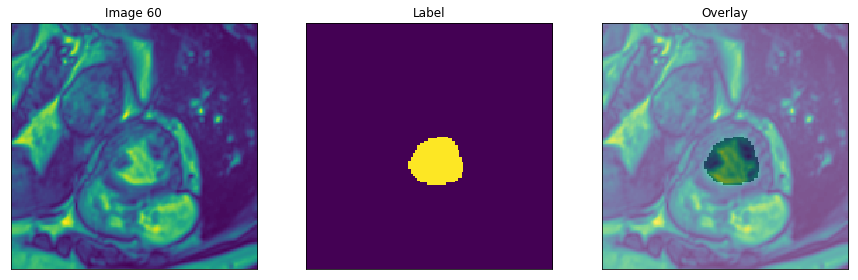

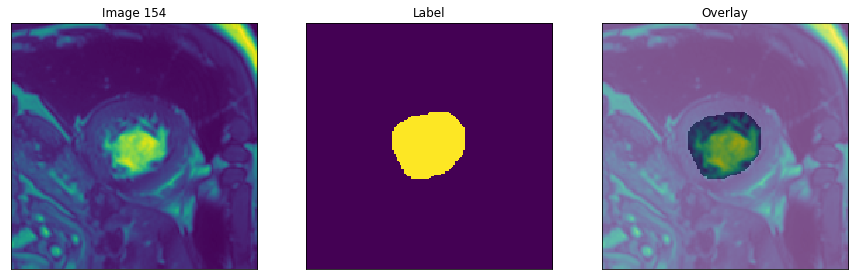

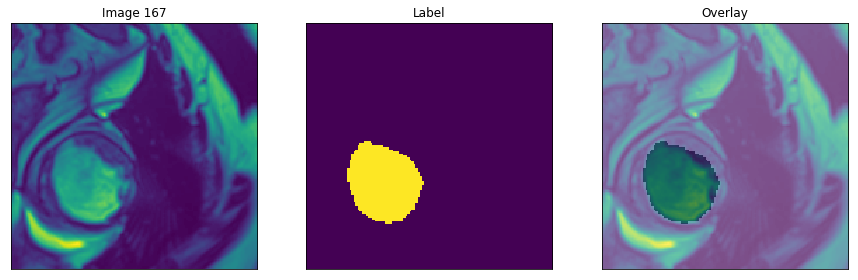

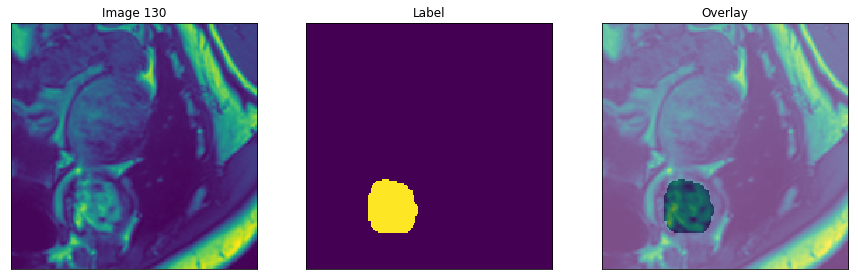

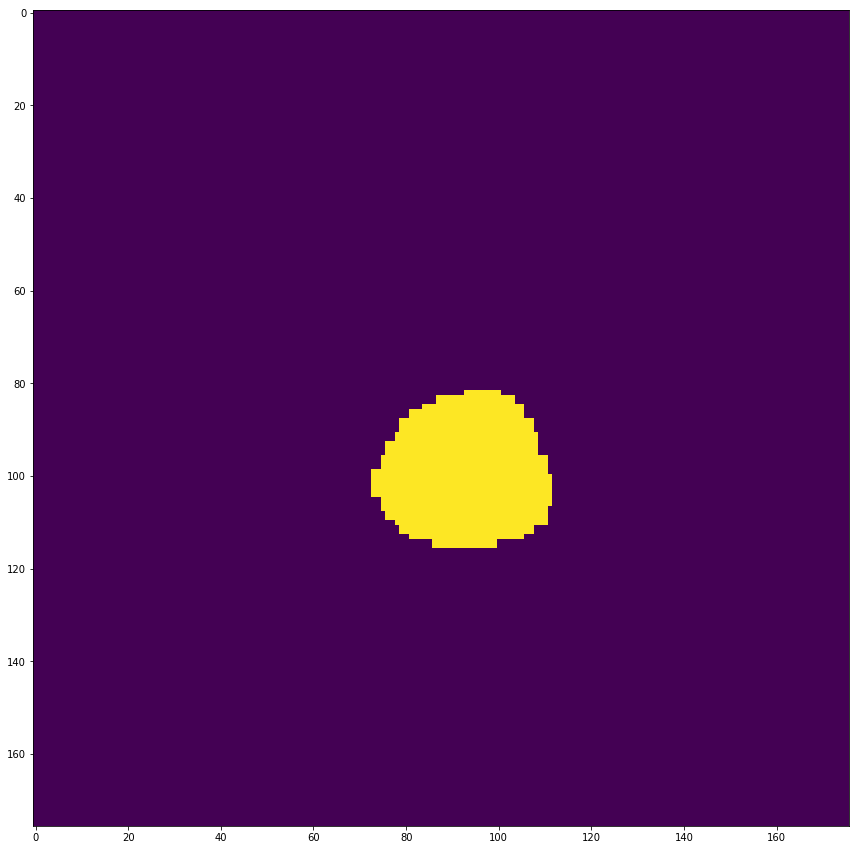

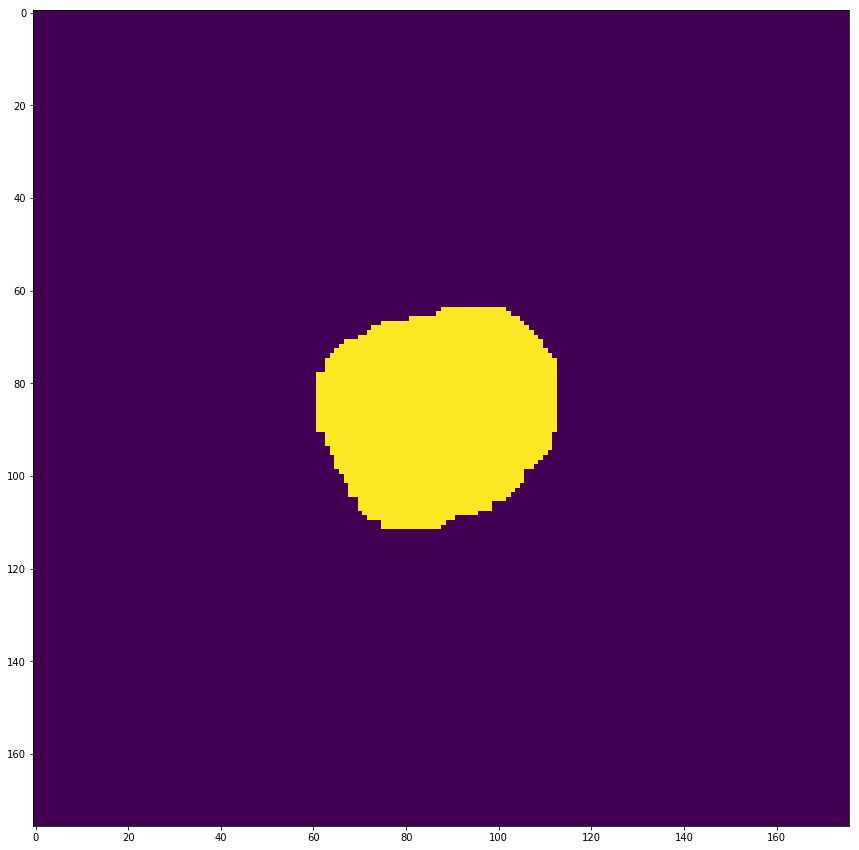

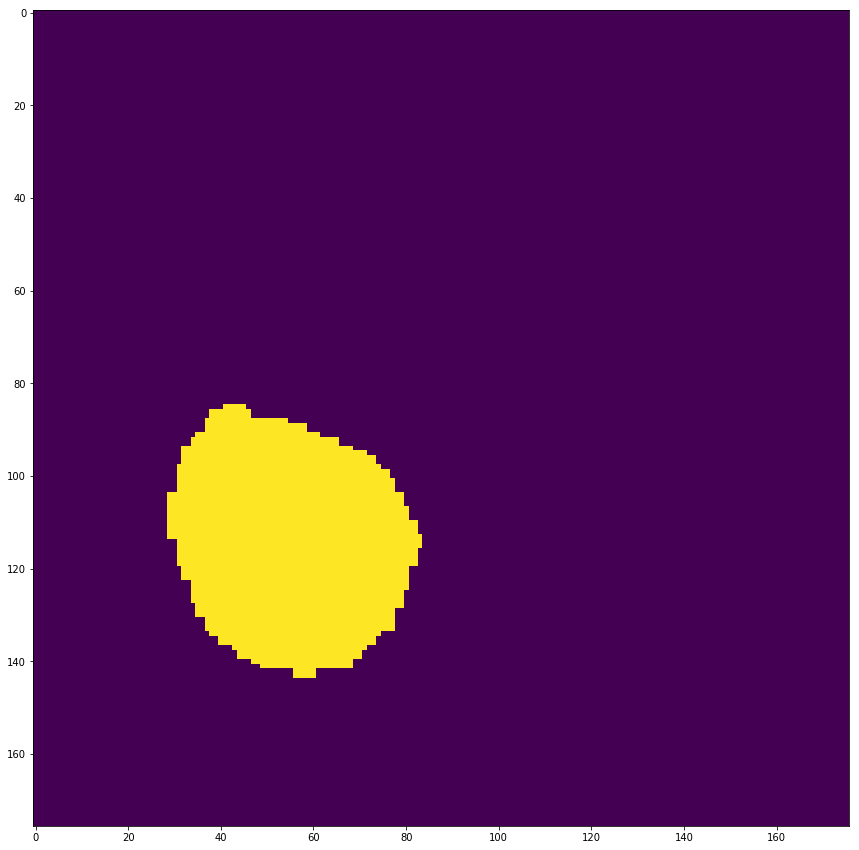

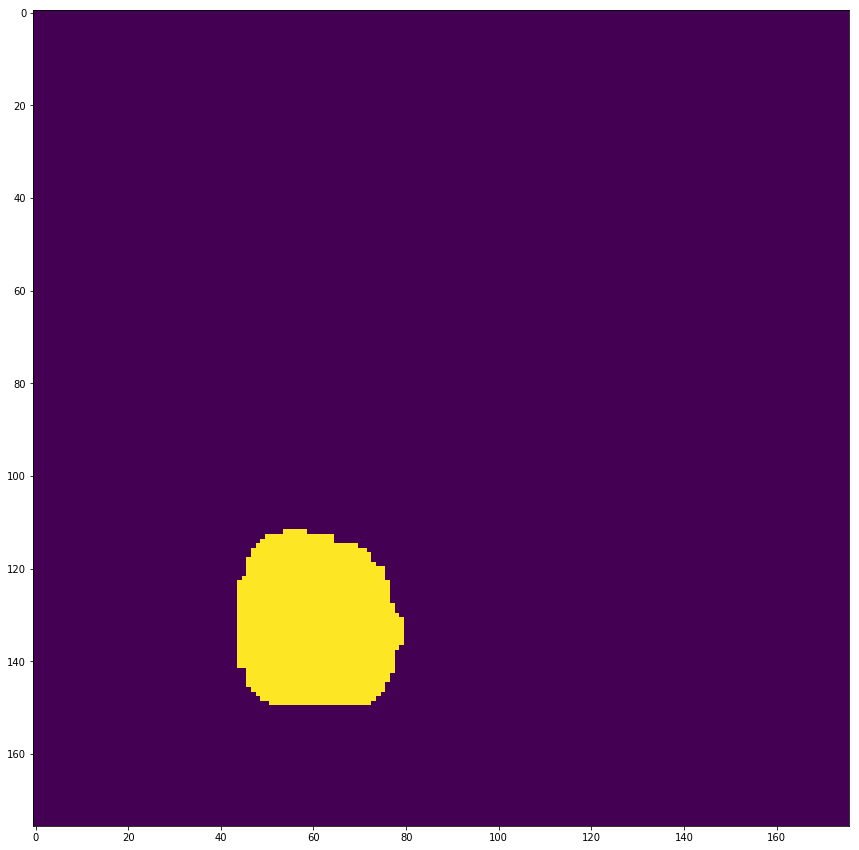

In [17]:
image_file = "/masvol/heartsmart/unet_model/data/baseline/acdc_1_3_176_test_images.npy"
label_file = "/masvol/heartsmart/unet_model/data/baseline/acdc_1_3_176_test_labels.npy"
display_images_labels(image_file, label_file, num_images = 4, random_images = True)

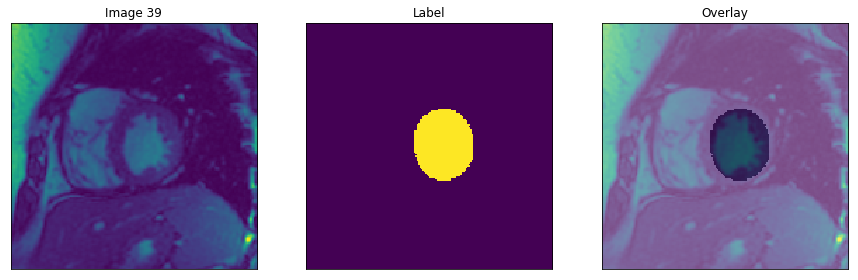

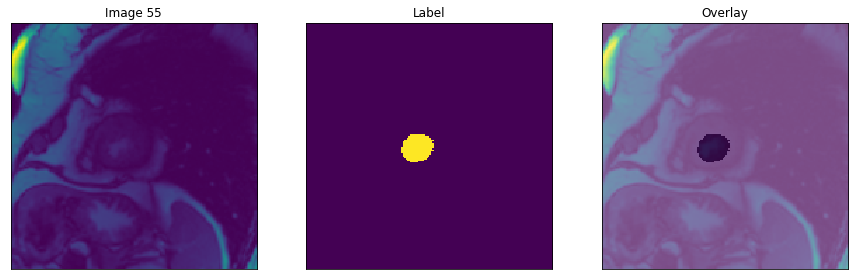

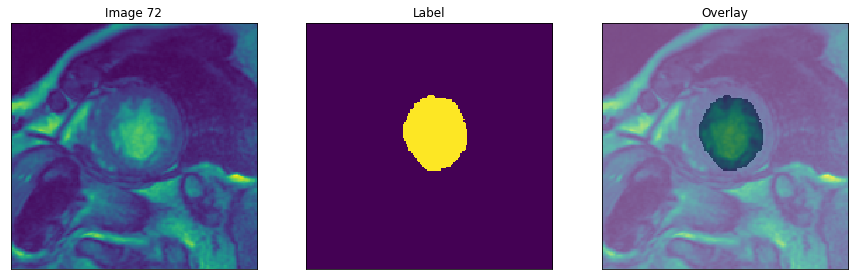

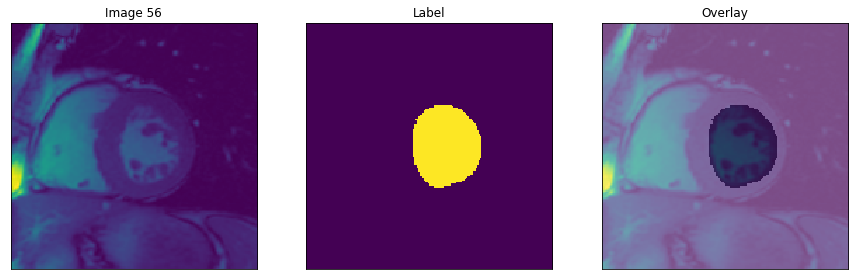

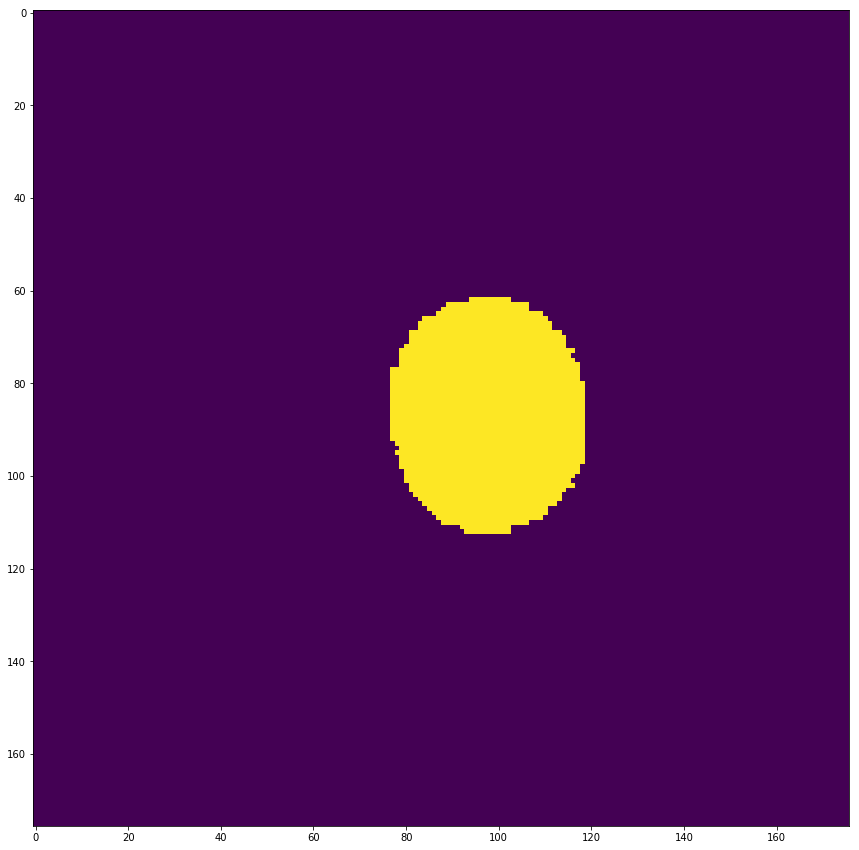

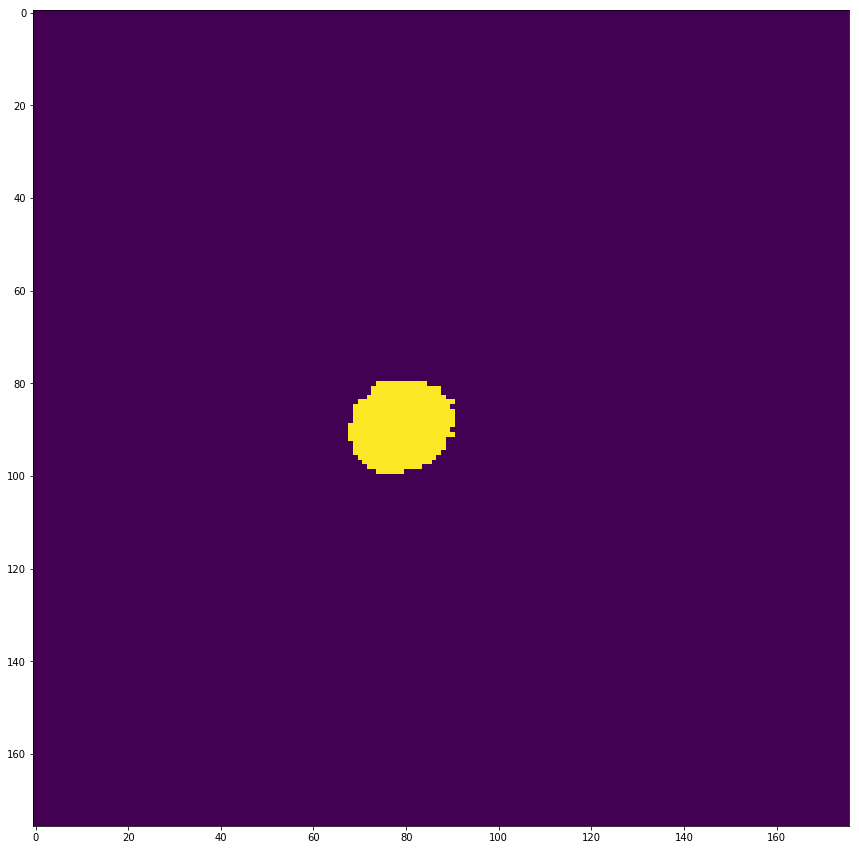

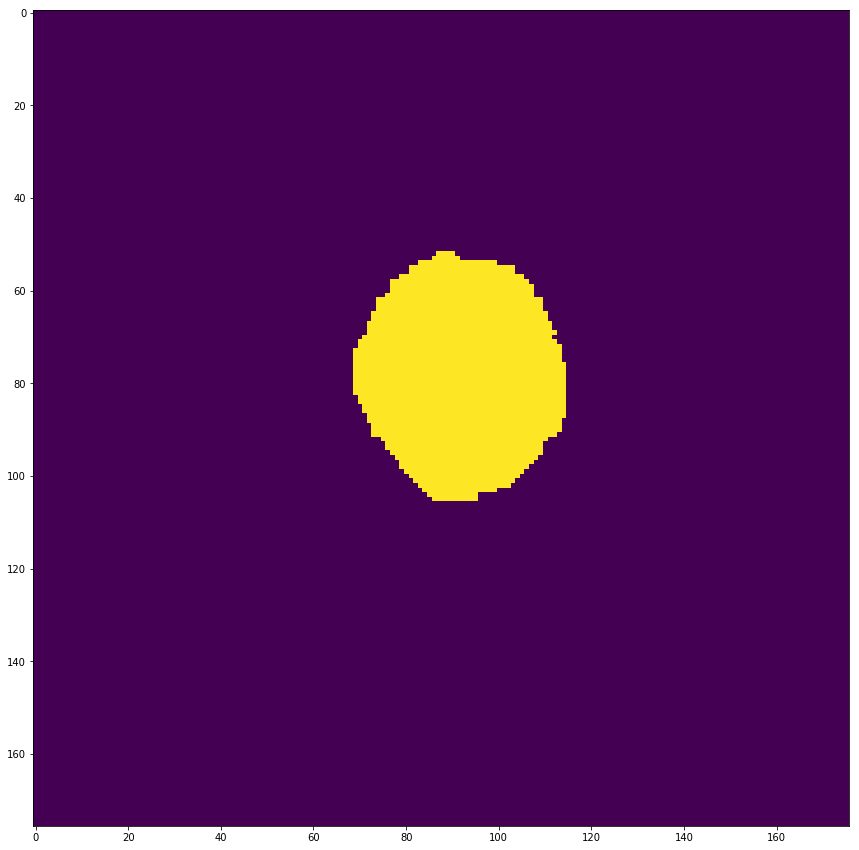

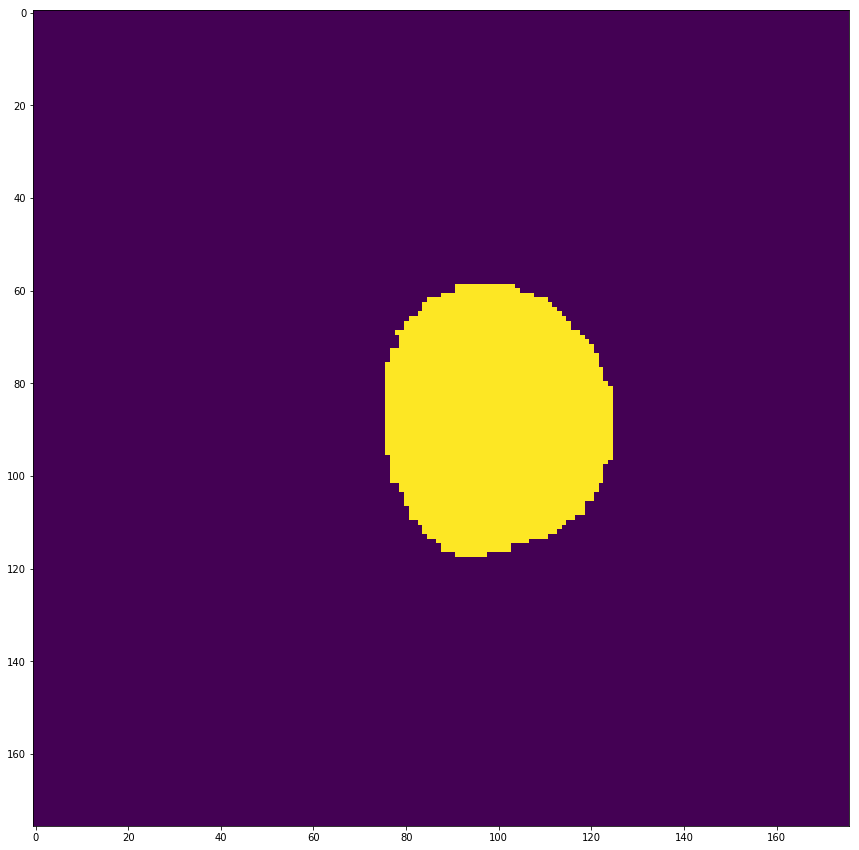

In [15]:
image_file = "/masvol/heartsmart/unet_model/data/baseline/sunnybrook_1_3_176_test_images.npy"
label_file = "/masvol/heartsmart/unet_model/data/baseline/sunnybrook_1_3_176_test_labels.npy"
display_images_labels(image_file, label_file, num_images = 4, random_images = True)

samples, max, min  260 1.0 0.0


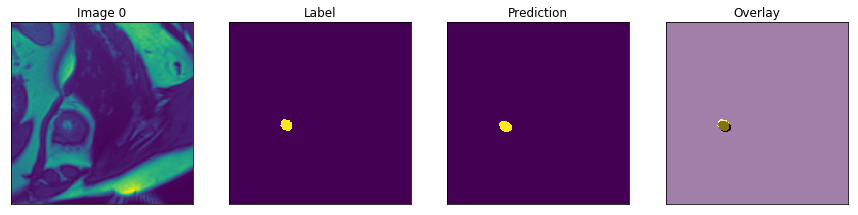

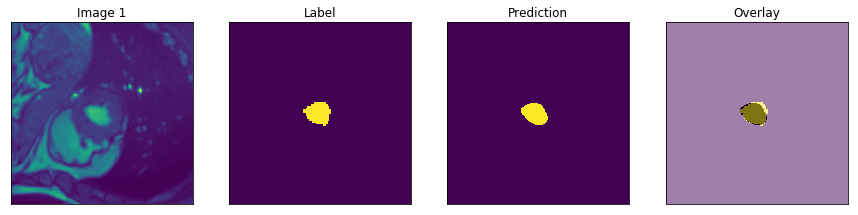

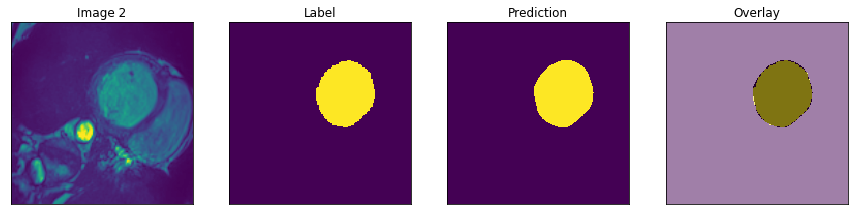

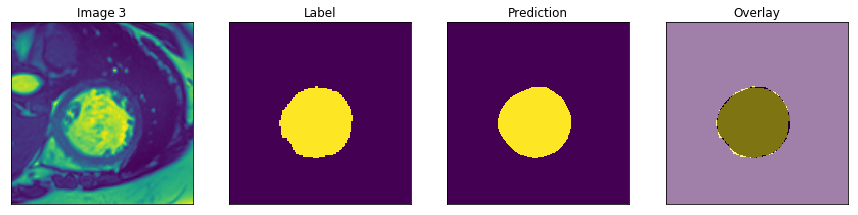

In [3]:
image_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_176_test_images.npy"
label_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_176_test_labels.npy"
pred_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_176_predictions.npy"
display_images_labels_predictions (image_file, label_file, pred_file, num_images = 4, random_images = False)


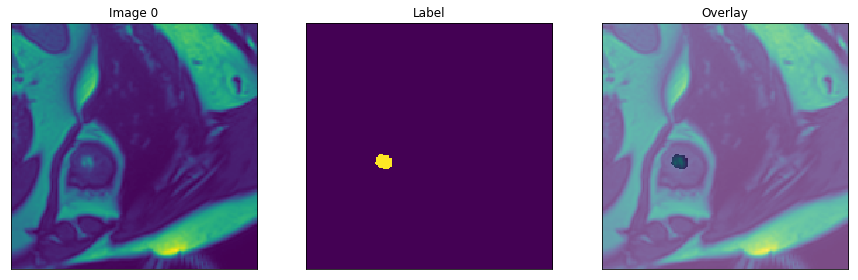

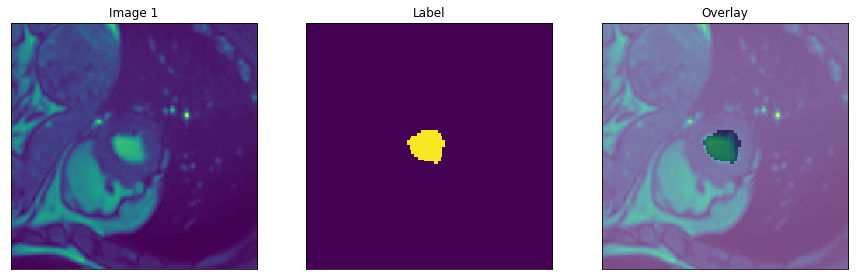

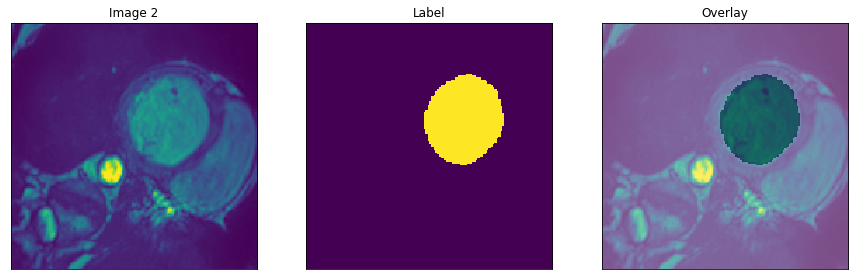

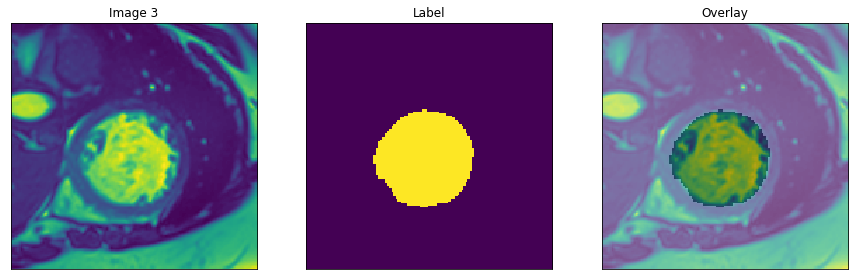

In [4]:
image_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_176_test_images.npy"
label_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_176_test_labels.npy"
display_images_labels(image_file, label_file, num_images = 4, random_images = False)

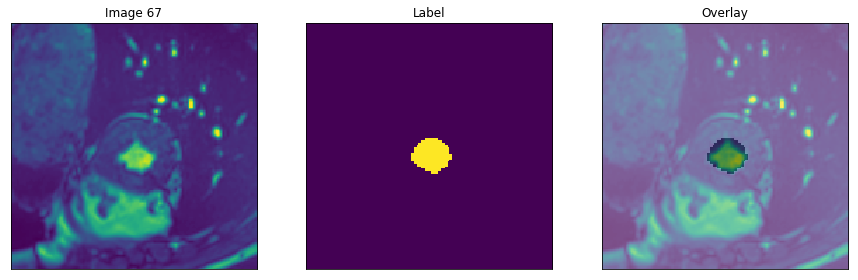

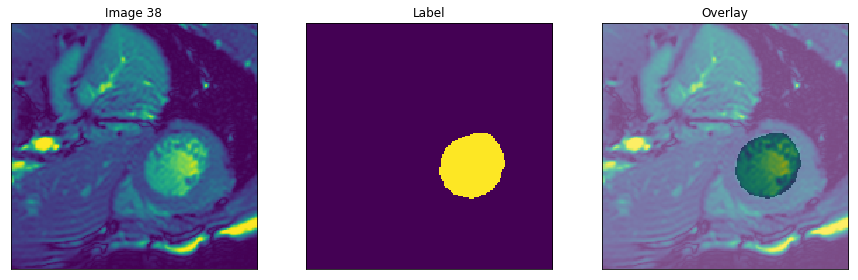

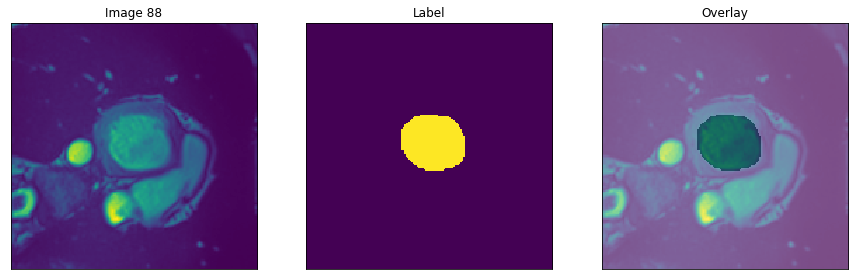

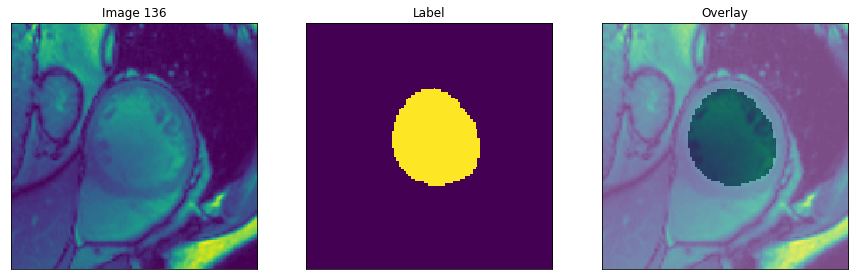

In [5]:
image_file = "/masvol/heartsmart/unet_model/data/baseline/acdc_1_3_176_test_images.npy"
label_file = "/masvol/heartsmart/unet_model/data/baseline/acdc_1_3_176_test_labels.npy"
display_images_labels(image_file, label_file, num_images = 4, random_images = True)

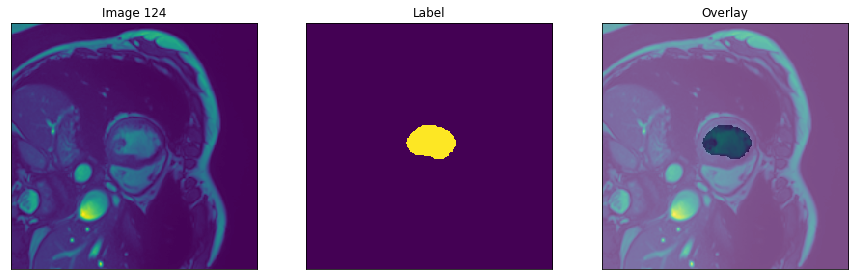

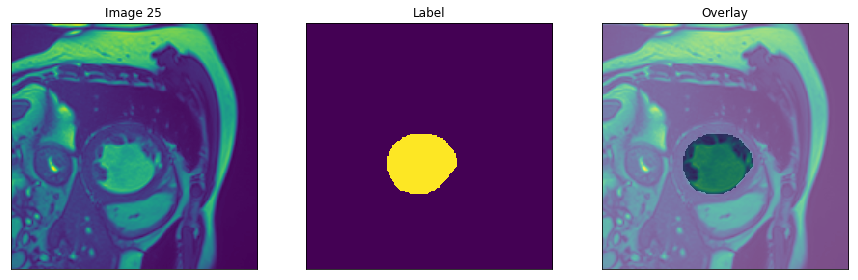

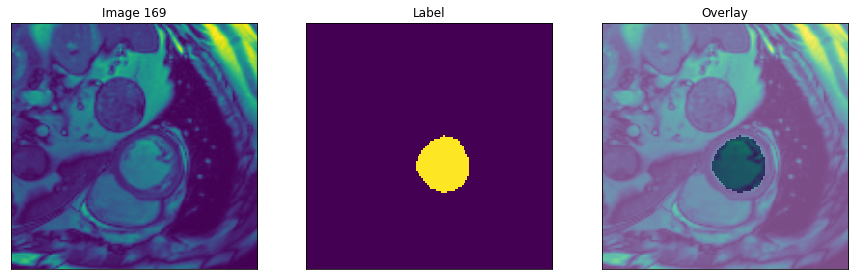

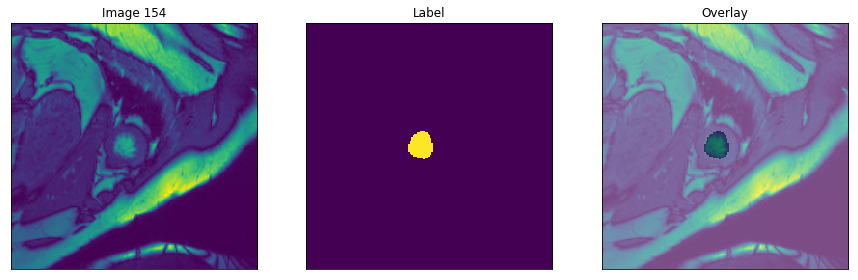

In [6]:
image_file = "/masvol/heartsmart/unet_model/data/baseline/acdc_1_3_256_test_images.npy"
label_file = "/masvol/heartsmart/unet_model/data/baseline/acdc_1_3_256_test_labels.npy"
display_images_labels(image_file, label_file, num_images = 4, random_images = True)

In [ ]:
image_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_176_test_images.npy"
pred_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_176_predictions.npy"
display_images_predictions (image_file, pred_file, num_images = 4, random_images = False)

In [ ]:
label_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_176_test_labels.npy"
pred_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_176_predictions.npy"

compute_losses (label_file, pred_file)


In [ ]:
perf_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_176_performance.json"
show_perf_values(perf_file)

In [ ]:
file_p = "/masvol/heartsmart/unet_model/data/baseline/sunnybrook_1_3_256_learning_history.json"
plot_accuracy_and_loss(file_p)

In [ ]:
file_p = "/masvol/heartsmart/unet_model/data/baseline/acdc_diceloss_1_3_176_learning_history.json"
plot_accuracy_and_loss(file_p)

In [ ]:
file_p = "/masvol/heartsmart/unet_model/data/baseline/combined_diceloss_1_3_176_learning_history.json"
plot_accuracy_and_loss(file_p)